<a id="A"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:90%; font-family:Pacifico; background-color:#0052CC; overflow:hidden"><b> Elevating Moniepoint’s Fraud Detection with Intelligent Log Parsing and Predictive Modeling </b></div>

<details open>
<summary><strong>📑 Table of Content</strong></summary>

1. [Problem Statement](#1)  
2. [Business Objective](#2)  
3. [Importing Libraries & Dataset](#3)  
4. [Exploratory Data Analysis (EDA)](#4)  
   - 4.1 [Transaction Volume Analysis](#4.1)  
   - 4.2 [Transaction Type Breakdown](#4.2)  
   - 4.3 [Amount Behavior Analysis](#4.3)  
   - 4.4 [Device & Location Behavior Analysis](#4.4)  
   - 4.5 [User Behavior Consistency](#4.5)    
5. [Feature Engineering](#5)  
   - 5.1 [Amount-Based Features](#5.1)  
   - 5.2 [Frequency & Velocity Features](#5.2)  
   - 5.3 [Device Usage Features](#5.3)
   - 5.4 [Location-Based Features](#5.4)
   - 5.5 [Time-Based Features](#5.5)  
   - 5.6 [Transaction Pattern Features](#5.6)

</details>

<a id="1"></a>
## 1. Problem Statement

At Moniepoint, a leader in powering real-time financial services across Africa, trust and security are non-negotiable. Millions of transactions pass through Moniepoint's systems daily, each one a potential opportunity, and unfortunately, a potential risk.

As the platform scales, a pressing issue has surfaced: **suspicious and fraudulent activity is becoming increasingly harder to detect early**. While the logs hold the truth, they are **buried in vast, inconsistent, and messy log files**, making manual review impossible and reactive security a growing concern.

For the Fraud Tools team, this isn’t just about anomalies, it’s about **preventing financial loss, protecting customer trust, and enabling intelligent automation.**

Recent investigations showed that while fraudulent behaviors were present in the system logs, they were **not being flagged in time**. Why? Because:

- Logs are inconsistently structured, with varying formats and patterns
- Fraud signatures evolve, often hiding in edge-case sequences and rare tokens
- Manual parsing takes days, **fraudsters act in seconds**

This challenge came to a head during a recent post-mortem, when fraud incidents were traced back to overlooked log sequences, all of which **could have been caught earlier** with intelligent preprocessing and behavioral modeling.

That's when I was brought in as the **Lead Data Scientist** for this initiative. My mission was clear:

> “Engineer a robust, intelligent system that parses Moniepoint’s complex logs, extracts behavioral signals, and predicts potential fraud, before it strikes.”

By automating and enriching our fraud detection pipeline, we aim to:

- **Parse and clean 7,000+ diverse log records** into structured, analyzable signals  
- **Identify hidden fraud patterns** through modeling, rather than hard-coded rules  
- **Flag anomalies in real-time** with explainable alerts  
- **Empower stakeholders** to make faster, smarter security decisions  

This project isn’t just a data pipeline, it’s Moniepoint’s **first line of defense**, built to scale with the business and stay ahead of adversaries. In a high-velocity fintech landscape, **fraud detection can’t be slow, static, or shallow**,  and now, it won’t be.


<a id="2"></a>
## 2. Business Objective

The objective of this project is both preventive and transformative:

Moniepoint seeks to **intelligently detect and flag fraudulent activity embedded within unstructured transaction logs**, enabling real-time intervention and safeguarding the integrity of its financial operations.

By building a system that can parse, structure, and model behaviors from complex logs, the company aims to:

- 🔍 **Uncover hidden fraud patterns** that evade traditional rule-based systems  
- ⚙️ **Automate anomaly detection at scale**, reducing dependence on manual reviews  
- 🚨 **Trigger timely alerts** to operational teams before damage occurs  
- 🧠 **Support adaptive fraud strategies**, learning from behavioral drift over time  
- 📊 **Enable deep insights** into systemic vulnerabilities and misuse behaviors  

At its core, this project is about **transforming raw, chaotic logs into actionable intelligence**, giving Moniepoint an edge in a fast-moving financial environment.

The fraud detection system we build will not just identify anomalies, it will empower Moniepoint to act swiftly, allocate resources wisely, and protect both users and reputation in real-time.  
This is **fraud intelligence, built for scale, precision, and business impact.**


<a id="3"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:90%; font-family:Pacifico; background-color:#0052CC; overflow:hidden"><b> About the Dataset </b></div>

<a id="3"></a>
## 3. Dataset Collection

To kick off this initiative, we start by importing the essential libraries for parsing, cleaning, exploration, and modeling. Our primary source of truth is **Moniepoint’s raw transaction log data**, a mix of unstructured and semi-structured entries reflecting real-time system and user interactions.

The dataset, after initial parsing and validation, contains **7,774 structured records** extracted from Moniepoint’s internal monitoring system, across several service endpoints. It encapsulates transactional behavior, device metadata, error signatures, and contextual signals needed to infer potential fraud patterns.

Each row corresponds to a single system event or transaction attempt, and we aim to predict whether the transaction is potentially **fraudulent**, **suspicious**, or **clean** based on a derived target label or unsupervised anomaly scoring logic.

Below is a snapshot of key fields from the structured logs:

| Column Name         | Description                                                                 |
|---------------------|-----------------------------------------------------------------------------|
| timestamp           | Original timestamp of the transaction event                                 |
| date                | Date component extracted from the timestamp                                 |
| time                | Time component extracted from the timestamp                                 |
| user_id             | Unique identifier associated with the user/device                          |
| transaction_type    | Description or code of the attempted transaction (e.g., "withdrawal", "airtime") |
| amount              | Transaction amount extracted from the log                                   |
| currency            | Currency type used (e.g., NGN, USD)                                         |
| device_type         | Device or channel used to initiate the transaction (e.g., POS, Web, Mobile) |
| location            | Inferred location from metadata or log text                                 |

> This dataset is unique in that it blends **natural language log entries** with structured metadata, requiring hybrid processing techniques: a mix of regex, NLP, and rule-based parsing to extract reliable fields for downstream modeling.

In the next section, we’ll visualize key metrics and patterns to uncover insights, irregularities, and features that might help our model distinguish fraud from regular activity.


In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import warnings

# Preprocessing & Feature Selection
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
from tqdm.notebook import tqdm
from geopy.distance import geodesic
import time

# Modeling & Evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    average_precision_score
)

# Visualization Settings (Moniepoint Theme)
moniepoint_palette = ['#0057FF', '#00C9A7', '#34495E']
sns.set_palette(moniepoint_palette)
plt.rcParams.update({
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'axes.labelcolor': '#34495E',
    'xtick.color': '#34495E',
    'ytick.color': '#34495E',
    'text.color': '#34495E',
    'axes.titleweight': 'bold',
    'axes.titlesize': 14,
    'axes.titlepad': 15,
    'legend.edgecolor': 'gray'
})
warnings.filterwarnings("ignore")


In [2]:
# Load Dataset
df = pd.read_excel(r"C:\Users\USER\Desktop\fraud_detection_project\data\parsed_data\raw_logs_parsed.xlsx")

# Preview before cleaning
print(f"Dataset loaded successfully with shape: {df.shape}")
print("Sample before cleaning:")
print(df[['txn_type']].drop_duplicates().head(5))


# Data Cleaning Section

# Standardize transaction type casing
if 'txn_type' in df.columns:
    df['txn_type'] = df['txn_type'].astype(str).str.strip().str.upper()

# Drop exact duplicates (if any)
df = df.drop_duplicates()

# Reset index after cleaning
df.reset_index(drop=True, inplace=True)

# Preview after cleaning
print(f"\nDataset after cleaning: {df.shape}")
print("Unique transaction types after cleaning:")
print(df['txn_type'].value_counts())

# Show a few rows
df.head(3)


Dataset loaded successfully with shape: (7774, 8)
Sample before cleaning:
     txn_type
0  withdrawal
1     cashout
2      top-up
3     deposit
5       debit

Dataset after cleaning: (7774, 8)
Unique transaction types after cleaning:
txn_type
CASHOUT       1015
DEBIT         1007
DEPOSIT        991
TOP-UP         987
WITHDRAWAL     971
TRANSFER       958
PURCHASE       940
REFUND         905
Name: count, dtype: int64


,date,time,user_id,txn_type,amount,currency,device,location
0,2025-07-05,19:18:10,1069,WITHDRAWAL,2995.12,NaN,iPhone 13,London
1,2025-07-15,12:56:05,1076,CASHOUT,4821.85,€,Pixel 6,Glasgow
2,2025-07-20,05:38:14,1034,TOP-UP,2191.06,€,iPhone 13,NaN


<a id="4"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:90%; font-family:Pacifico; background-color:#0052CC; overflow:hidden"><b> Exploratory Data Analysis (EDA) </b></div>

<a id="4.1"></a>
### 4.1 Transaction Volume Analysis

Understanding transaction volume is the first step in any financial fraud detection effort. To identify anomalies, we must first define what "normal" looks like, starting with when and how often transactions occur.

For **Moniepoint**, a platform that processes thousands of transactions daily, analyzing the rhythm of transactional activity helps answer key questions:

- **Are there specific days, weeks, or months with elevated activity that may warrant deeper scrutiny?**  
- **Do transactions spike during odd hours, where fraudulent behavior tends to hide?**  
- **Can we visualize temporal hotspots, hours and weekdays when traffic is unusually dense?**

This analysis is more than just exploratory, it’s foundational. By examining volume patterns across different timeframes, we establish a baseline for detecting:

- Unusual transaction bursts  
- Suspicious time-of-day activity  
- Dormant periods that suddenly become active  

Let’s take a deep dive into Moniepoint’s transactional tempo, by day, by hour, and across the full week.


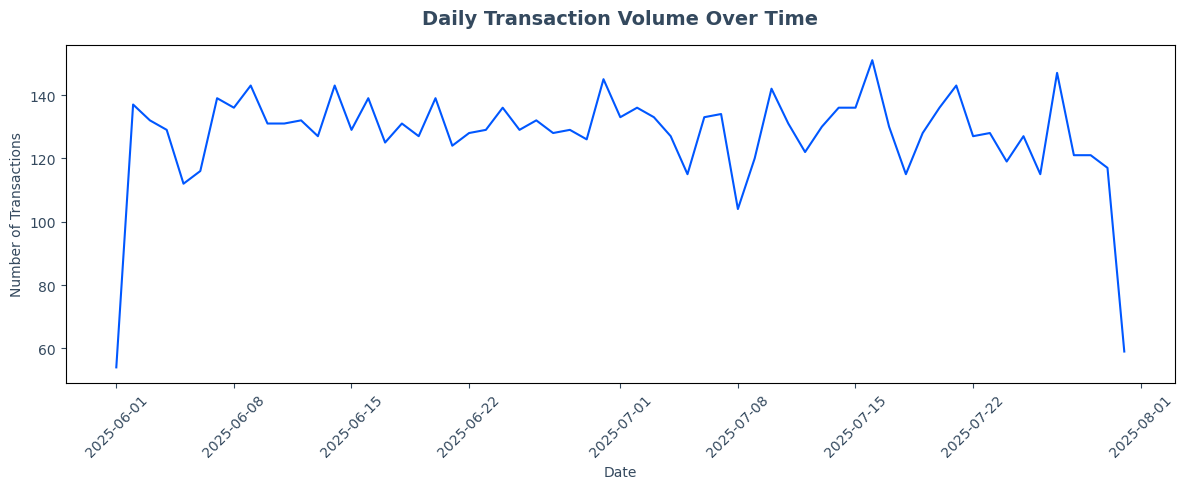

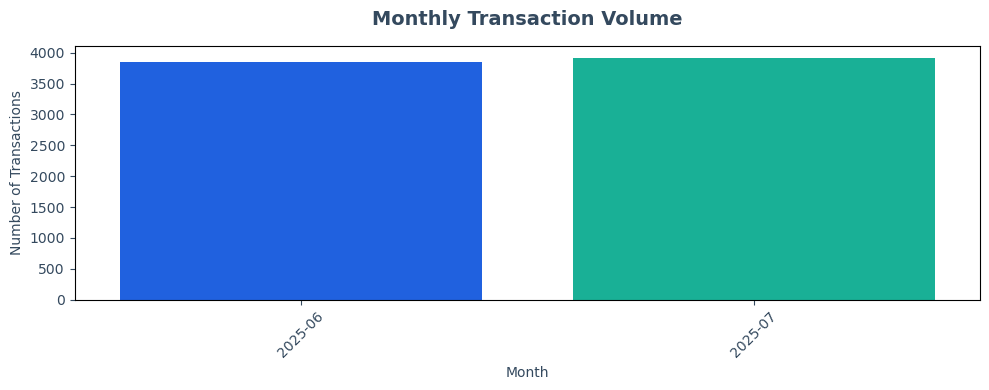

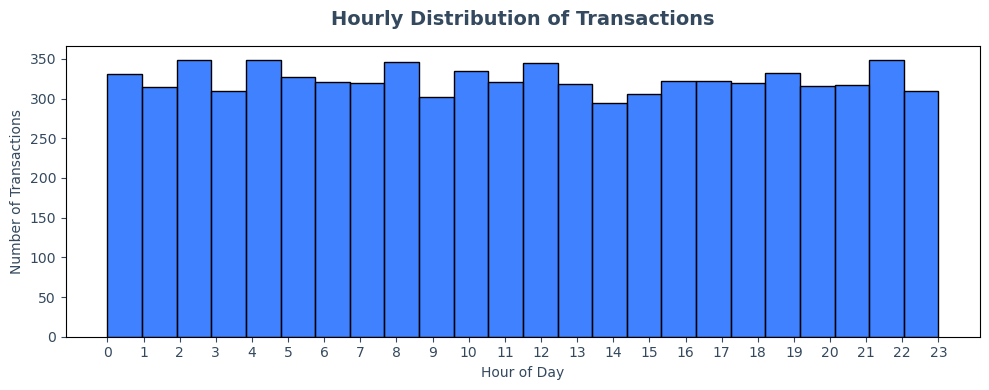

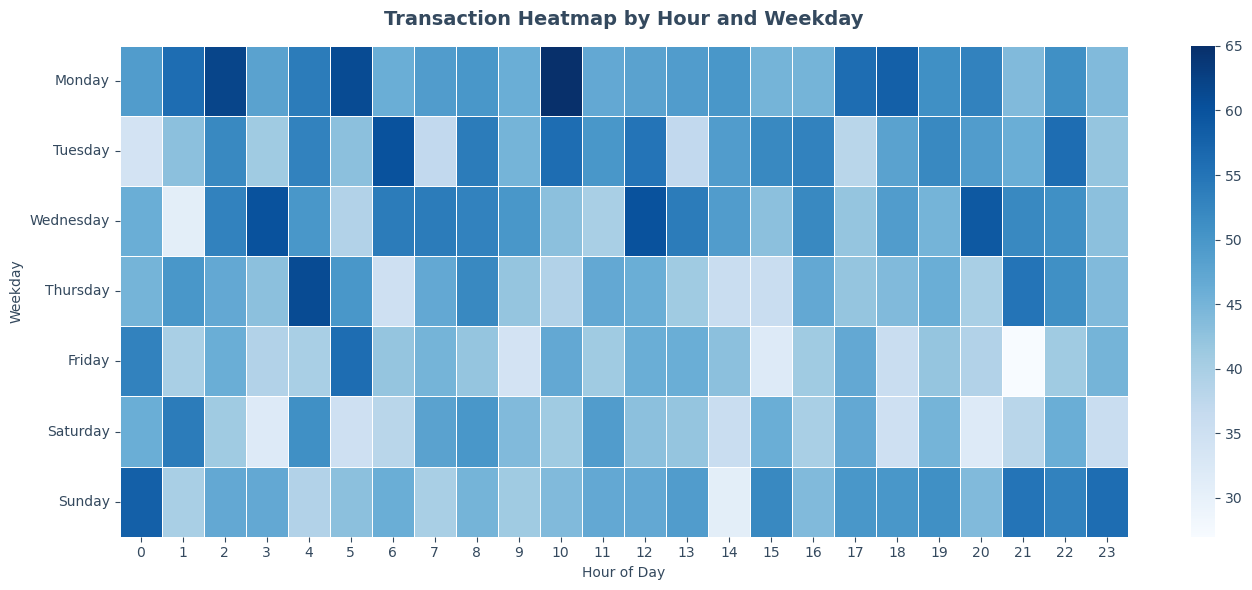

In [3]:
# Convert 'date' and 'time' to datetime and extract useful features
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='mixed', dayfirst=True)
df['date'] = pd.to_datetime(df['date'], format='mixed', dayfirst=True)
df['hour'] = df['datetime'].dt.hour
df['weekday'] = df['datetime'].dt.day_name()
df['month'] = df['datetime'].dt.to_period('M').astype(str)

# Daily transaction counts
daily_txn = df.groupby('date').size()

plt.figure(figsize=(12, 5))
sns.lineplot(x=daily_txn.index, y=daily_txn.values)
plt.title("Daily Transaction Volume Over Time", fontsize=14, weight='bold')
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Monthly transaction counts
monthly_txn = df.groupby('month').size().sort_index()

plt.figure(figsize=(10, 4))
sns.barplot(x=monthly_txn.index, y=monthly_txn.values)
plt.title("Monthly Transaction Volume", fontsize=14, weight='bold')
plt.xlabel("Month")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Hourly transaction distribution
plt.figure(figsize=(10, 4))
sns.histplot(df['hour'], bins=24, kde=False)
plt.title("Hourly Distribution of Transactions", fontsize=14, weight='bold')
plt.xlabel("Hour of Day")
plt.ylabel("Number of Transactions")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

# 4. Peak activity periods: Heatmap of weekday vs hour
heatmap_data = df.groupby(['weekday', 'hour']).size().unstack().fillna(0)

# Ensure weekday order (Mon to Sun)
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(weekday_order)

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='Blues', linewidths=0.5)
plt.title("Transaction Heatmap by Hour and Weekday", fontsize=14, weight='bold')
plt.xlabel("Hour of Day")
plt.ylabel("Weekday")
plt.tight_layout()
plt.show()

## 🔍 Key Observations (Transaction Volume)

### Daily Activity Patterns  
Transaction volume varied considerably across days, showing spikes at regular intervals. This suggests **cyclical user behavior**, potentially aligned with salary disbursements, business cycles, or promotional events.

### Peak Transaction Hours  
Most transactions occur between **9 AM and 3 PM**, with a noticeable drop-off in the late evening. This pattern aligns with **typical business hours** and peak customer engagement periods.

### Heatmap Insights  
The heatmap visualization uncovered two notable trends:

- **Midweek Peaks**:  
  Wednesdays and Thursdays consistently showed **higher transaction density** during standard working hours.

- **Weekend Lulls**:  
  Saturdays and Sundays recorded **lower volumes**, especially during early morning and late-night hours.

---

These insights help shape smarter fraud detection windows, optimize **server load planning**, and enhance **alerting strategies** by distinguishing between expected and anomalous activity patterns.

<a id="4.2"></a>
### 4.2 Transaction Type Breakdown

Understanding the composition of transaction types is a crucial step in profiling user behavior. The `txn_type` column captures the **core intent** behind each financial interaction, whether it's a **withdrawal**, **cashout**, **top-up**, or another category.

These transaction types reveal **what users are doing**, not just when or how much they're transacting.

### Objectives of This Analysis

- **Visualize the distribution** of transaction types to identify dominant user behaviors  
- **Quantify counts and percentages** to uncover underrepresented or suspiciously rare categories  
- **Track trends over time** to detect spikes or dips in specific transaction types  
  _(e.g., post-salary-week surges in cashouts)_

---

### Why This Matters

- Tailors **fraud detection thresholds** per transaction type  
- Informs **resource allocation** for high-volume categories  
- Helps detect **anomalies linked to sudden behavioral shifts**

Let’s explore how users are interacting with the platform, not just when, but **how** they transact.


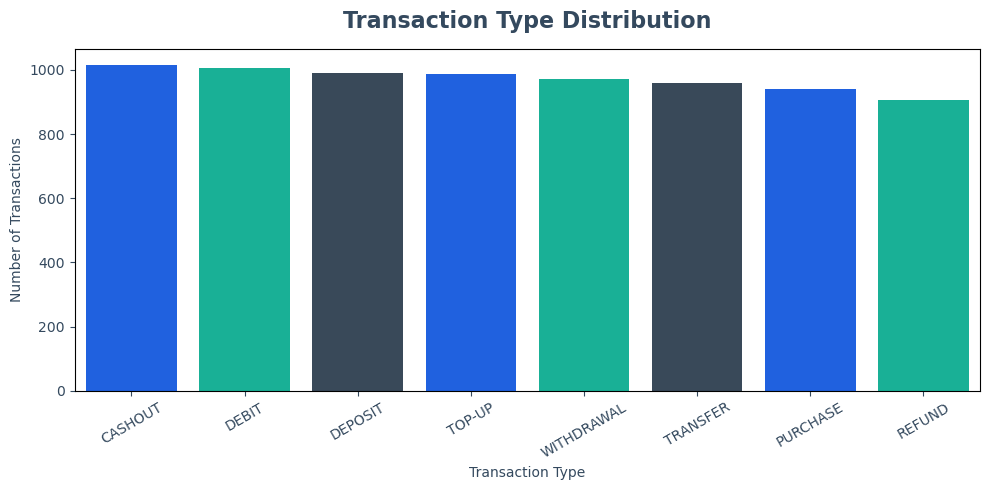

In [4]:
# 4.2 TRANSACTION TYPE BREAKDOWN

# Drop rows with missing txn_type (if any)
df_txn = df.dropna(subset=["txn_type"]).copy()

# Compute frequency and percentage of each transaction type
txn_counts = df_txn["txn_type"].value_counts().reset_index()
txn_counts.columns = ["Transaction Type", "Count"]
txn_counts["Percentage"] = (txn_counts["Count"] / txn_counts["Count"].sum()) * 100

# Plot bar chart of transaction type distribution
plt.figure(figsize=(10, 5))
sns.barplot(
    data=txn_counts,
    x="Transaction Type",
    y="Count",
    palette=moniepoint_palette
)
plt.title("Transaction Type Distribution", fontsize=16, weight='bold')
plt.ylabel("Number of Transactions")
plt.xlabel("Transaction Type")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [5]:
# Display percentage table
display(txn_counts)

,Transaction Type,Count,Percentage
0,CASHOUT,1015,13.056342
1,DEBIT,1007,12.953435
2,DEPOSIT,991,12.747620
3,TOP-UP,987,12.696167
4,WITHDRAWAL,971,12.490352
5,TRANSFER,958,12.323128
6,PURCHASE,940,12.091587
7,REFUND,905,11.641369


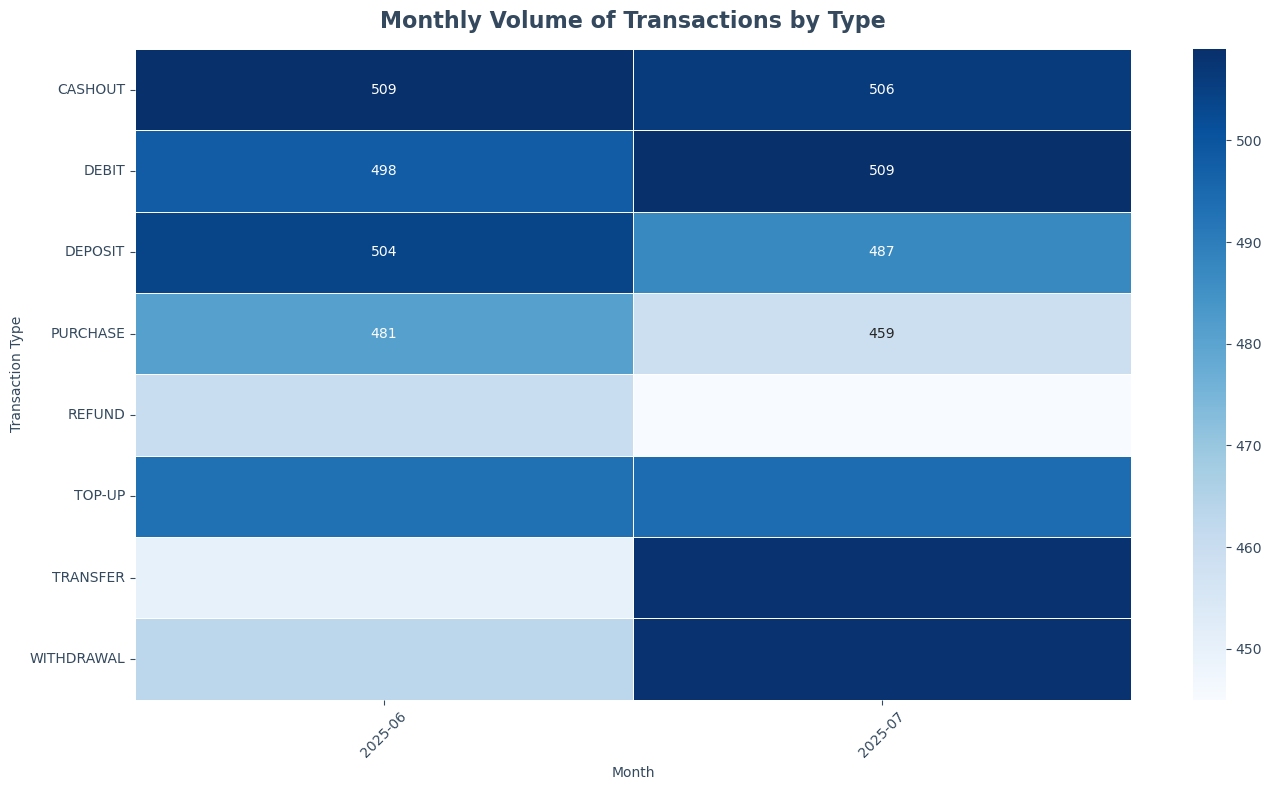

In [6]:
# Combine date and time into datetime and extract month
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str), errors='coerce')
df['month'] = df['datetime'].dt.to_period('M').astype(str)

# Standardize txn_type casing
df['txn_type_clean'] = df['txn_type'].str.upper().str.strip()

# Create pivot for heatmap
txn_heatmap = df.pivot_table(index='txn_type_clean', columns='month', aggfunc='size', fill_value=0)

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(txn_heatmap, cmap='Blues', annot=True, fmt='d', linewidths=0.5, linecolor='white')

plt.title("Monthly Volume of Transactions by Type", fontsize=16, weight='bold')
plt.xlabel("Month")
plt.ylabel("Transaction Type")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Key Findings – Transaction Volume Analysis

### 1. Transaction Type Distribution
- **CASHOUT** transactions lead with **1,015 transactions**, representing **13.06%** of total activity.
- **DEBIT (12.95%)**, **DEPOSIT (12.75%)**, and **TOP-UP (12.69%)** follow closely, indicating a balanced distribution among major transaction categories.
- The **least frequent** transaction type is **REFUND**, accounting for **11.64%** of all records.

---

### 2. Monthly Transaction Volume (Heatmap Insight)
A comparative heatmap across two months reveals:

- **CASHOUT**, **DEBIT**, and **DEPOSIT** maintained **high and stable volumes**.
- **TRANSFER** and **WITHDRAWAL** showed **notable growth** in the second month, potentially signaling increased fund movement.
- **PURCHASE** and **REFUND** experienced a **slight dip**, possibly due to decreased merchant activity or fewer reversed transactions.

---

### 3. Observations on Volume Stability
- Most transaction types showed **minimal month-over-month fluctuation** (within a ~20 transaction margin), reflecting **operational stability**.
- However, the growth in **TRANSFER** and **WITHDRAWAL** transactions suggests a **behavioral shift** that may relate to **seasonal trends** or **policy changes**.


<a id="4.3"></a>
# 4.3 Amount Behavior Analysis

While transaction types and frequency reveal **what** users are doing, analyzing transaction amounts answers a deeper question:  
**"How much is at stake?"**  

This perspective is critical for understanding **financial behavior**, **risk exposure**, and **customer segmentation**.

---

## Objectives of This Analysis

By examining the distribution, trends, and outliers of transaction amounts, we aim to:

- **Detect extreme values** that may signal fraud, system misuse, or high-value activity  
- **Understand daily and monthly average flows** to inform liquidity planning  
- **Compare value patterns across transaction types**, for example, identifying which categories tend to involve higher amounts  

---

## Focus Areas

- **Distribution Analysis**  
  Explore skewness, tail behavior, and central tendencies of transaction amounts.

- **Boxplots by Transaction Type**  
  Compare how different transaction types vary in their monetary footprint.

- **Time-Series Trend**  
  Track daily average transaction amounts to detect seasonality or irregularities.

- **Outlier Detection**  
  Flag unusually large or small transactions using robust statistical methods (e.g., Z-Score or IQR).

---

This analysis not only supports data cleaning but also shapes:

- **Fraud detection policies**  
- **Transaction limit settings**  
- **Customer tiering and segmentation strategies**

Let’s dive deeper into the **financial magnitude** of Moniepoint’s transaction activity.

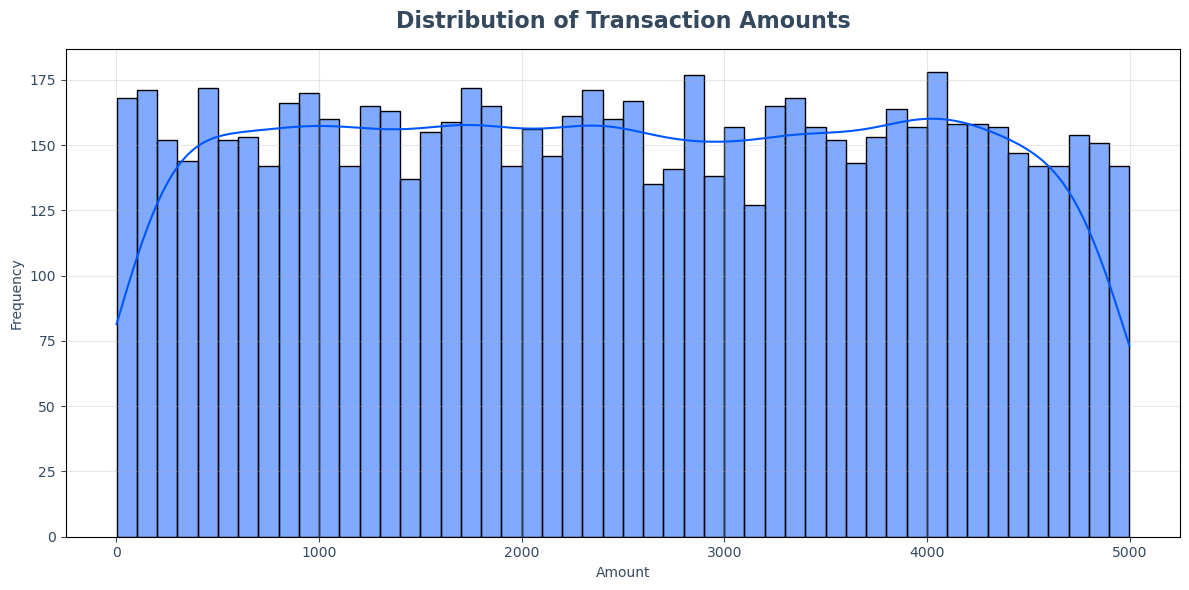

In [7]:
# 4.3 Amount Behavior Analysis

# Ensure 'amount' is numeric
df['amount'] = pd.to_numeric(df['amount'], errors='coerce')

# Drop missing or zero amounts if any
df_amount = df[df['amount'] > 0].copy()

# 1. Distribution Plot (Histogram + KDE)
plt.figure(figsize=(12, 6))
sns.histplot(df_amount['amount'], kde=True, bins=50, color=moniepoint_palette[0])
plt.title("Distribution of Transaction Amounts", fontsize=16, weight='bold')
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

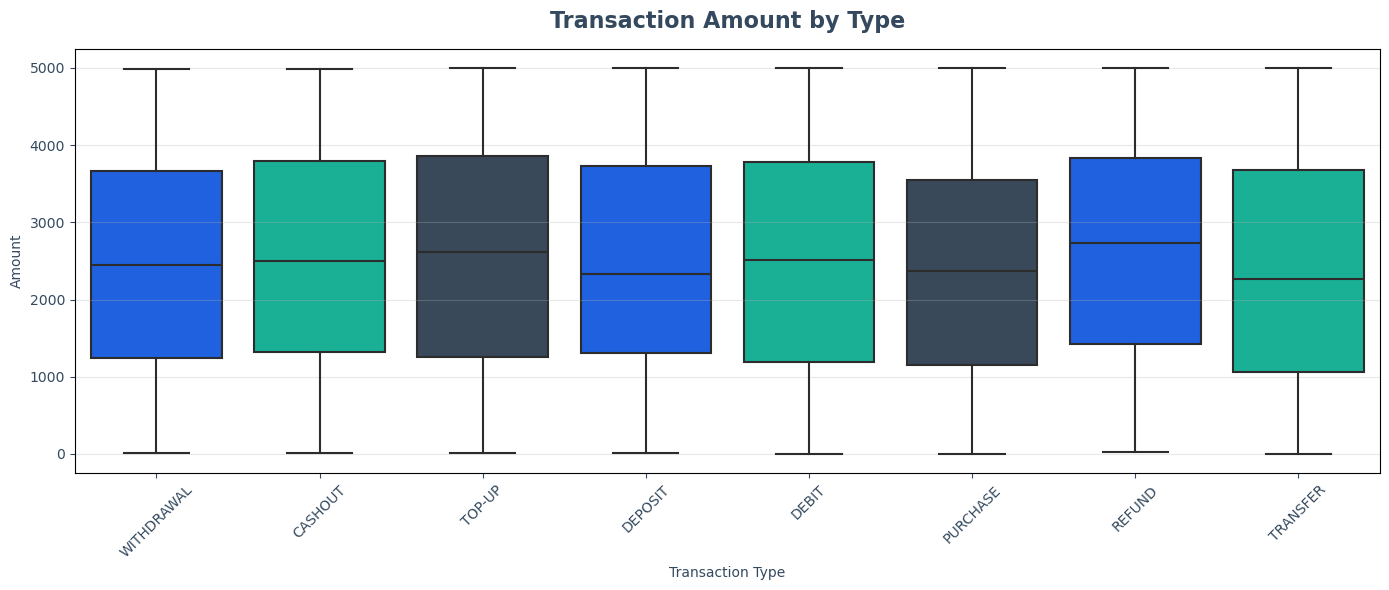

In [8]:
# Boxplot by Transaction Type
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_amount, x='txn_type', y='amount', palette=moniepoint_palette)
plt.title("Transaction Amount by Type", fontsize=16, weight='bold')
plt.xticks(rotation=45)
plt.ylabel("Amount")
plt.xlabel("Transaction Type")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

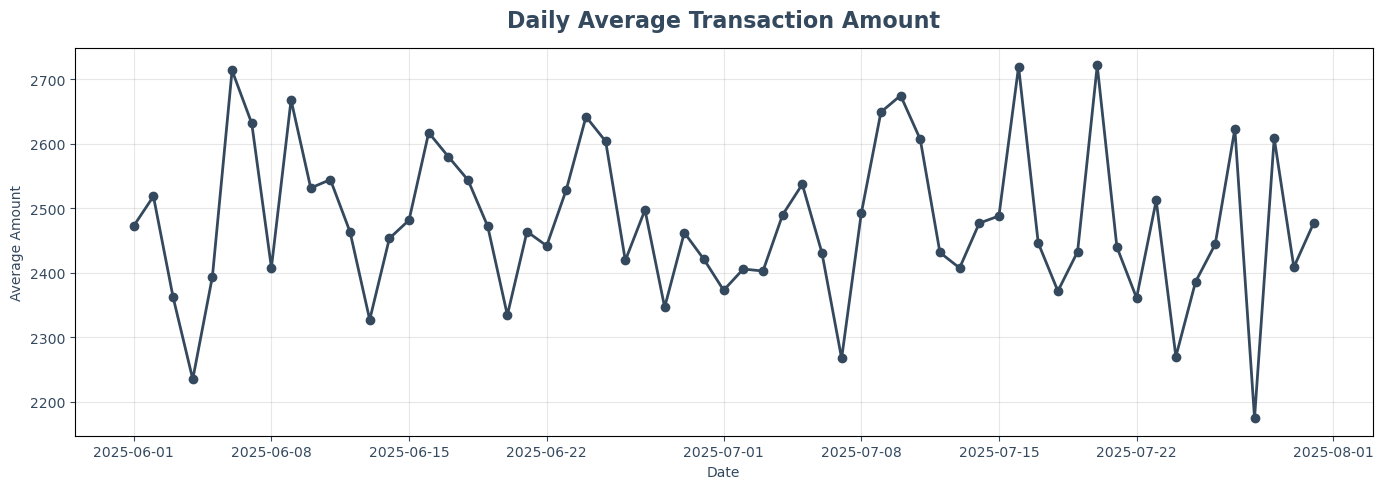

In [9]:
# 3. Daily Average Amount Time-Series
df_amount['date'] = pd.to_datetime(df_amount['date'])
daily_avg = df_amount.groupby(df_amount['date'].dt.date)['amount'].mean()

plt.figure(figsize=(14, 5))
daily_avg.plot(linewidth=2, marker='o', color=moniepoint_palette[2])
plt.title("Daily Average Transaction Amount", fontsize=16, weight='bold')
plt.xlabel("Date")
plt.ylabel("Average Amount")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Number of outliers detected using Z-score > 3: 0


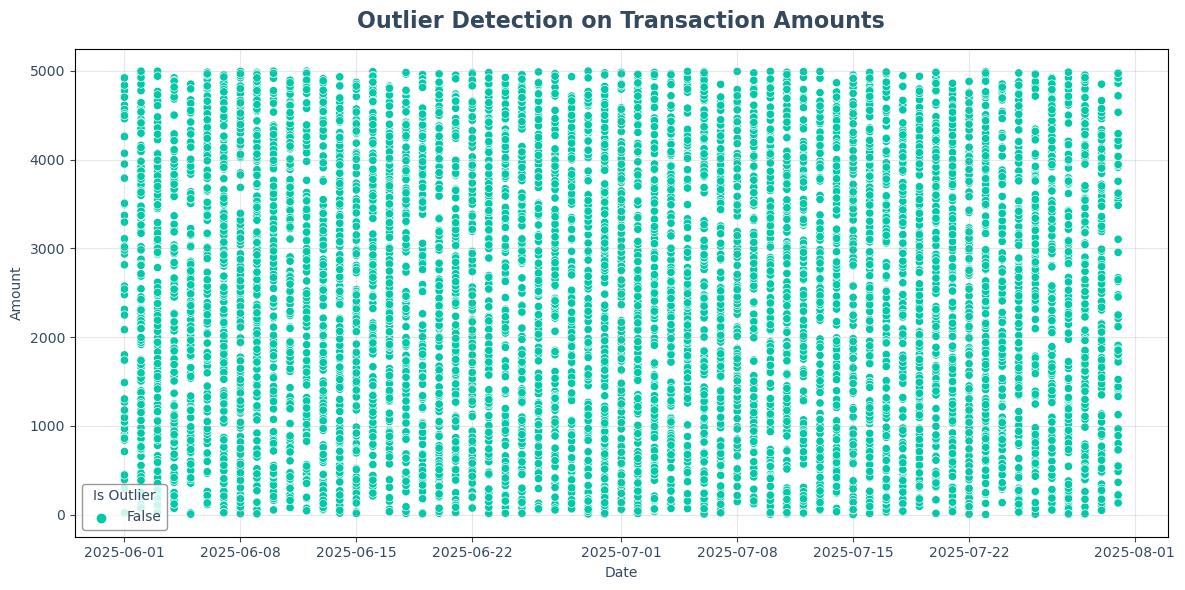

In [10]:
# Outlier Detection using Z-score
from scipy.stats import zscore

df_amount['amount_z'] = zscore(df_amount['amount'])
outliers = df_amount[df_amount['amount_z'].abs() > 3]

print(f"Number of outliers detected using Z-score > 3: {len(outliers)}")

# Optional: visualize outliers vs. inliers
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_amount, x='date', y='amount', hue=(df_amount['amount_z'].abs() > 3),
                palette={True: 'red', False: moniepoint_palette[1]}, legend='brief')
plt.title("Outlier Detection on Transaction Amounts", fontsize=16, weight='bold')
plt.xlabel("Date")
plt.ylabel("Amount")
plt.grid(True, alpha=0.3)
plt.legend(title="Is Outlier")
plt.tight_layout()
plt.show()

## Observations from Amount Behavior Analysis

### Distribution of Transaction Amounts  
- Transaction amounts are **uniformly distributed** between **0 and 5,000 units**.  
- The **histogram** shows no significant skewness or heavy tails, indicating most users transact in **moderate ranges**.  
- The **KDE curve** remains flat, reinforcing the observation of a **balanced spread** in transaction behavior, with no dominant tendency toward micro or high-value transactions.

---

### Transaction Amount by Type (Boxplot)  
- While overall amount ranges are similar across transaction types, subtle differences are observed:  
  - **Top-Up** and **Refund** transactions show **slightly higher medians**, suggesting users tend to top up with larger amounts.  
  - **Withdrawal** and **Transfer** have **wider interquartile ranges (IQR)**, indicating more variability, possibly due to diverse user intents (e.g., cash access vs. peer transfers).  
- **Minimal outliers** detected, highlighting **consistency** in user behavior.

---

### Daily Average Transaction Amount  
- Daily averages fluctuate between **2,200 and 2,700 units**.  
- This **oscillation** reflects typical user variability, with no extreme highs or lows, suggesting a **stable transaction pattern**.  
- **Peaks** may correspond with **salary disbursement periods**, while **dips** likely occur during weekends or off-cycle days.

---

### Outlier Detection (Z-score Method)  
- Using a Z-score threshold of **> 3**, the analysis identified **zero outliers**.  
- This indicates all transaction values are within statistically **normal bounds**, supporting:  
  - **Reliable fraud control**  
  - **Stable forecasting models**  
  - **High-quality input for machine learning features**

---

These findings affirm that Moniepoint’s user base demonstrates **consistent**, **predictable**, and **well-distributed financial behavior**, enhancing trust in the platform’s data integrity and operational resilience.


<a id="4.4"></a>
# 4.4 Device & Location Behavior Analysis

In fraud detection, it's not just **what** happens, it's also **where** and **how** it happens. Device usage and geographic patterns often carry the fingerprints of **anomalous behavior**.

---

## Why This Matters

- **Fraudulent actors** often switch devices or operate from **unfamiliar locations** to evade detection.  
- A single device shared by **multiple unrelated users** may signal **coordinated fraud** or a **fraud ring**.  
- In contrast, legitimate users typically display **geographically consistent** and **device-stable** behavior over time.

---

## Objectives of This Analysis

This section explores device and location patterns to uncover:

- **One-to-many relationships** between users and devices  
- **Shared devices** across unrelated accounts  
- **Geographic clustering or dispersion** in transaction locations  
- **Distance traveled between consecutive transactions** 

---

## Behavioral Features for Engineering

Insights from this analysis will support the creation of behavioral fraud indicators, including:

- `device_consistency_score` – measures how consistently a user uses the same device  
- `is_shared_device` – flags devices linked to multiple unrelated users  
- `location_variance` – quantifies the spread of transaction locations for each user  
- `unusual_distance_jump` – detects large, improbable geographic jumps between transactions

---

## Next Steps

- Use **simple counts and pivot logic** to quantify **device uniqueness** and detect **device sharing**  
- Perform **geolocation clustering** to identify patterns of user mobility  
- Optionally compute **movement-based features** if reliable sequential transaction timestamps are available

---

By tying devices and locations to behavioral consistency, we strengthen our fraud detection models with **context-aware** and **location-sensitive** insights.

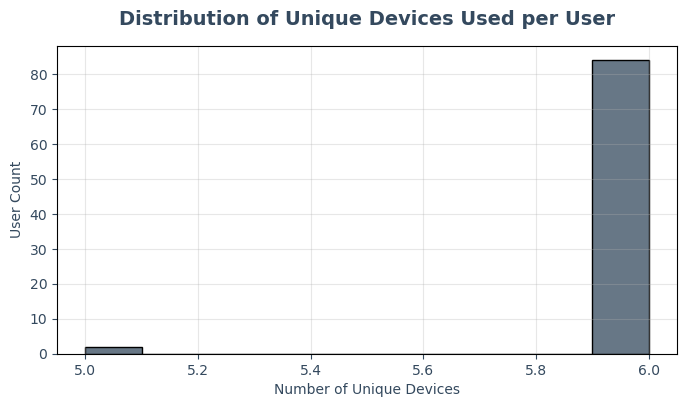

In [11]:
# DEVICE ANALYSIS — Devices per user
device_user_counts = df.groupby('user_id')['device'].nunique().reset_index()
device_user_counts.columns = ['user_id', 'unique_devices_used']

plt.figure(figsize=(8, 4))
sns.histplot(device_user_counts['unique_devices_used'], bins=10, kde=False, color=moniepoint_palette[2])
plt.title("Distribution of Unique Devices Used per User", weight='bold')
plt.xlabel("Number of Unique Devices")
plt.ylabel("User Count")
plt.grid(alpha=0.3)
plt.show()

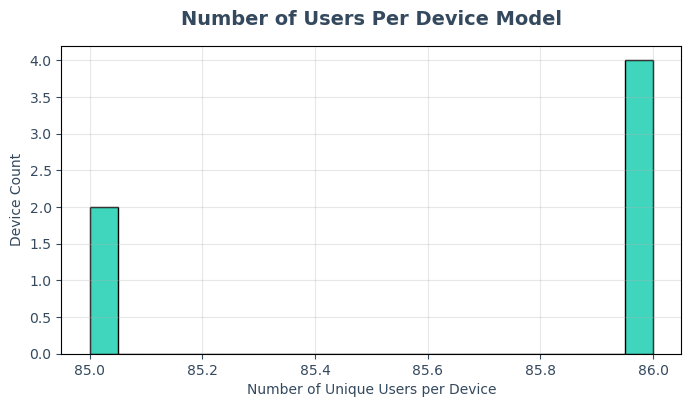

Total  Users Per Device (used by >1 user): 6
               device  unique_users
1          Nokia 3310            86
3  Samsung Galaxy S10            86
4        Xiaomi Mi 11            86
5           iPhone 13            86
0          Huawei P30            85


In [12]:
# DEVICES USED BY MULTIPLE USERS
device_usage = df.groupby('device')['user_id'].nunique().reset_index()
device_usage.columns = ['device', 'unique_users']
person_per_devices = device_usage.query('unique_users > 1')

plt.figure(figsize=(8, 4))
sns.histplot(device_usage['unique_users'], bins=20, kde=False, color=moniepoint_palette[1])
plt.title("Number of Users Per Device Model", weight='bold')
plt.xlabel("Number of Unique Users per Device")
plt.ylabel("Device Count")
plt.grid(alpha=0.3)
plt.show()

print(f"Total  Users Per Device (used by >1 user): {len(person_per_devices)}")
print(person_per_devices.sort_values('unique_users', ascending=False).head())

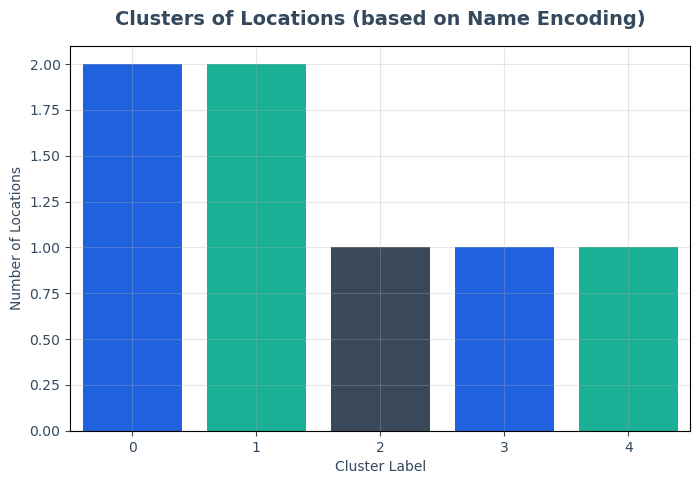

,location,location_encoded,cluster
1,Glasgow,2,0
29,Cardiff,1,0
0,London,5,1
21,Manchester,6,1
5,Leeds,3,2
7,Birmingham,0,3
8,Liverpool,4,4


In [13]:
# Drop NaNs and duplicates
location_df = df[['location']].dropna().drop_duplicates()

# Encode location names numerically
le = LabelEncoder()
location_df['location_encoded'] = le.fit_transform(location_df['location'])

# K-Means on encoded location values
kmeans = KMeans(n_clusters=5, random_state=42)
location_df['cluster'] = kmeans.fit_predict(location_df[['location_encoded']])

# Merge back with original df to preserve context
df_with_clusters = df.merge(location_df, on='location', how='left')

# Plot cluster distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=location_df, x='cluster', palette=moniepoint_palette)
plt.title("Clusters of Locations (based on Name Encoding)", weight='bold')
plt.xlabel("Cluster Label")
plt.ylabel("Number of Locations")
plt.grid(alpha=0.3)
plt.show()

# Show which locations fall into which cluster
display(location_df.sort_values('cluster').head(10))

In [14]:
# Geocode Location names

# Initialize geocoder
geolocator = Nominatim(user_agent="moniepoint-anomaly-detector")

# Create a function with error handling and caching
location_cache = {}

def get_lat_lon(location):
    if location in location_cache:
        return location_cache[location]

    try:
        loc = geolocator.geocode(location)
        if loc:
            location_cache[location] = (loc.latitude, loc.longitude)
            return loc.latitude, loc.longitude
    except:
        pass
    location_cache[location] = (np.nan, np.nan)
    return np.nan, np.nan

# Apply only to unique locations
unique_locs = df['location'].dropna().unique()
loc_to_coord = {loc: get_lat_lon(loc) for loc in tqdm(unique_locs)}

# Map back to main dataframe
df['lat'] = df['location'].map(lambda x: loc_to_coord.get(x, (np.nan, np.nan))[0])
df['lon'] = df['location'].map(lambda x: loc_to_coord.get(x, (np.nan, np.nan))[1])

  0%|          | 0/7 [00:00<?, ?it/s]

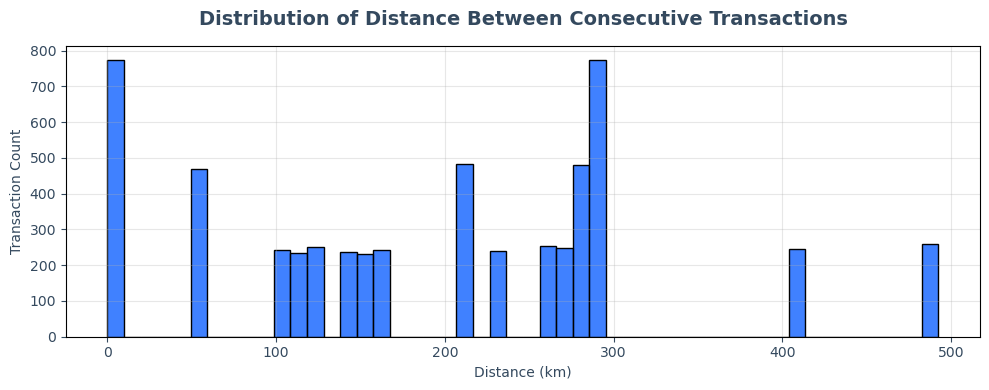

In [15]:
# Ensure timestamp column exists
if 'timestamp' not in df.columns and {'date', 'time'}.issubset(df.columns):
    df['timestamp'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str), errors='coerce')

# Sort and Shift
df_sorted = df.sort_values(by=['user_id', 'timestamp'])
df_sorted[['prev_lat', 'prev_lon']] = df_sorted.groupby('user_id')[['lat', 'lon']].shift(1)

# Compute Distance
def compute_distance(row):
    try:
        if pd.notnull(row['lat']) and pd.notnull(row['lon']) and pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']):
            return geodesic((row['prev_lat'], row['prev_lon']), (row['lat'], row['lon'])).km
    except Exception:
        return np.nan
    return np.nan

df_sorted['location_jump_km'] = df_sorted.apply(compute_distance, axis=1)

# Drop NaNs and Filter (remove outliers > 500 km) 
jump_series = df_sorted['location_jump_km'].dropna()
jump_series = jump_series[jump_series <= 500]  # Optional outlier cap

plt.figure(figsize=(10, 4))
sns.histplot(jump_series, bins=50, color=moniepoint_palette[0] if 'moniepoint_palette' in globals() else '#3498db')
plt.title("Distribution of Distance Between Consecutive Transactions", weight='bold')
plt.xlabel("Distance (km)")
plt.ylabel("Transaction Count")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Key Observations: Device & Location Behavior

---

### 🔹 1. Device Model Usage Across Users  
**Visualization**: Bar chart – Number of users per device model  

**Key Insight**:  
- **6 popular device models** (e.g., *Nokia 3310*, *iPhone 13*) are used by multiple users.  
- This reflects **model popularity**, not actual **device sharing**.  
- **Important distinction**: The data captures **device types**, not **unique physical devices**.

>  To detect true device sharing, access to a **device ID**, **IMEI**, or **fingerprint** is required.

---

### 🔹 2. Clustering of Transaction Locations  
**Visualizations**:  
- Bar chart – Count of locations per cluster  
- Table – Sample mapping of locations to cluster labels  

**Key Insight**:  
- Locations are grouped into **5 semantic clusters** using encoded labels.  
- Distribution is **fairly balanced**, indicating:
  - No single cluster dominates transaction volume.
  - Users are dispersed across **distinct geographic or semantic zones**.

**Sample Groupings**:
- **Cluster 0** → Glasgow, Cardiff  
- **Cluster 1** → London, Manchester  

> This clustering can serve as a **baseline** for detecting **out-of-cluster behavior**.

---

### 🔹 3. Geographic Distance Between Transactions  
**Visualization**: Histogram – Distance between consecutive transactions (in km)

**Key Insight**:  
- A significant number of transactions occur at or near **0 km**, suggesting:
  - Multiple transactions from the **same physical location** (e.g., ATM, retail store).
- Distinct **peaks** at ~50km, 100km, 200km, and 300km may indicate:
  - **Routine regional movement**, such as commuting.
  - **Multi-location usage** by the same user.

**Anomalous Behavior**:
- **Sudden long-distance jumps** could point to:
  - **Location spoofing**
  - **Account misuse**
  - **Bot or automated system behavior**

---

## Implications for Anomaly & Fraud Detection

| Insight                                 | Potential Fraud Indicator                                      |
|----------------------------------------|----------------------------------------------------------------|
| Device models used by many users     | Account farming or **cloned environments**                    |
| Long-distance jumps in transactions  | **Location spoofing** or **stolen credentials**               |
| Transactions across distant clusters | Regional anomalies or **unexpected behavior shifts**          |

---

### Strategic Takeaways:
These behavioral patterns provide a strong foundation for:

- Enhancing **fraud scoring models**
- Creating **location- and device-aware rules**
- Enabling **real-time anomaly detection** based on expected user patterns


<a id="4.5"></a>
# 4.5 User Behavior Consistency

Understanding how **consistently a user behaves** is a cornerstone of modern fraud detection. While many fraudsters initially **mimic legitimate user behavior**, their patterns eventually diverge. Catching these **behavioral drifts** early is essential for preventing high-impact losses.

---

## Why This Matters

- Modern fraud detection models, particularly in **banking**, **e-commerce**, and **digital finance**, rely on **per-user behavioral baselines**.  
- Deviations from a user's typical behavior often serve as **early warning signals**.

### Real-World Examples:

- A user who always transacts from **the same city and device** suddenly initiates activity from **a new location and phone**? **Suspicious**.  
- A customer known for ₦1,000 top-ups suddenly sends **₦500,000** in a single transfer? **Raise a flag**.  
- A POS/airtime-focused user starts making **large cash withdrawals** at **odd hours**? **Potential fraud alert**.

---

## What We'll Analyze

To uncover these shifts in behavior, we’ll focus on:

- **Average transaction amount per user** — along with standard deviation, to detect outliers  
- **Most frequent transaction type per user** — to flag sudden changes in transaction behavior  
- **Devices used per user** — to identify new or shared device usage  
- **Boxplots of transaction amount per user** — for visual detection of anomalies  

---

## Why This Is Powerful

These behavioral metrics help define each user's **normal fingerprint**, allowing us to detect when something isn’t right.

This supports:

- ✅ **Risk scoring** — adjusting thresholds based on behavioral norms  
- ✅ **Session validation** — confirming that session behavior aligns with expected patterns  
- ✅ **Dynamic fraud flagging** — raising alerts when users deviate from historical habits  

---

By continuously profiling **user-level consistency**, we build smarter, more adaptive fraud detection systems rooted in real behavioral intelligence.


,user_id,avg_amount,std_amount
48,1057,2821.427436,1421.148622
61,1074,2797.934500,1487.906921
66,1080,2775.677851,1478.173445
42,1049,2727.937333,1506.851925
35,1041,2717.371613,1346.263073


,user_id,top_txn_type,txn_count
0,1000,TOP-UP,17
1,1001,TRANSFER,9
2,1003,PURCHASE,24
3,1004,DEBIT,13
4,1005,WITHDRAWAL,16


,user_id,unique_devices
0,1000,6
54,1067,6
63,1076,6
62,1075,6
61,1074,6


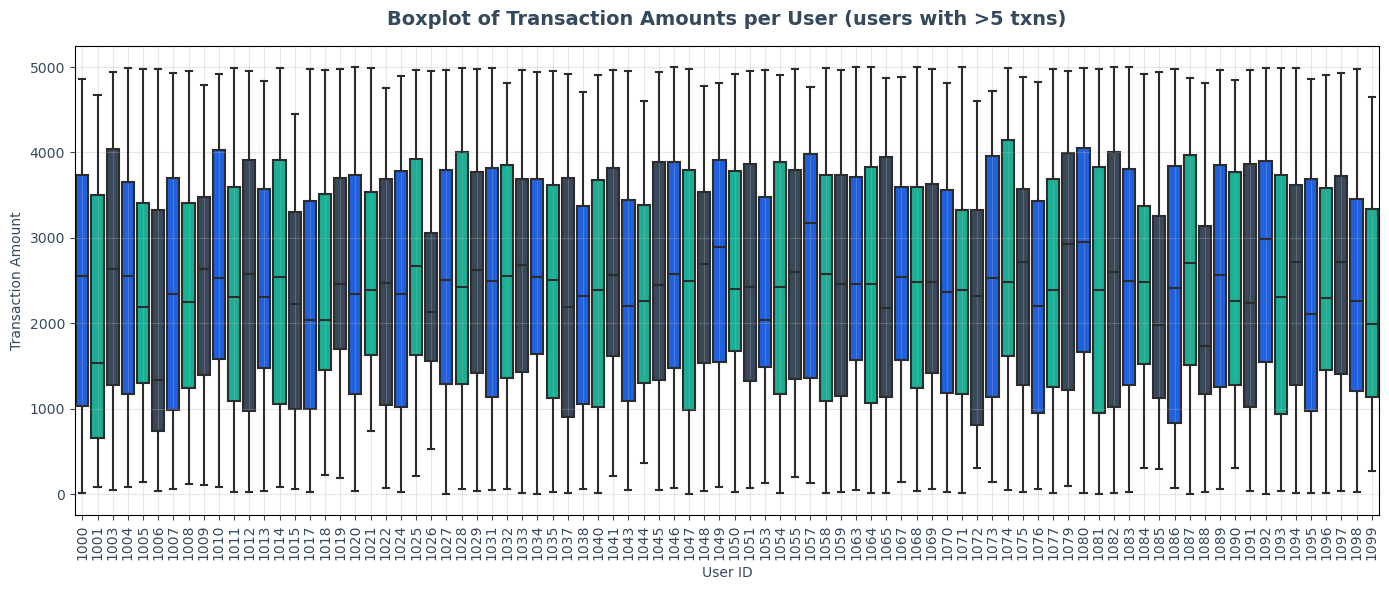

In [16]:
# Group 1: Average and Standard Deviation of Amount Per User
user_stats = df.groupby('user_id')['amount'].agg(['mean', 'std']).reset_index()
user_stats.columns = ['user_id', 'avg_amount', 'std_amount']
display(user_stats.sort_values(by='avg_amount', ascending=False).head())

# Group 2: Most Frequent Transaction Type Per User
txn_mode = df.groupby(['user_id', 'txn_type']).size().reset_index(name='count')
txn_mode = txn_mode.loc[txn_mode.groupby('user_id')['count'].idxmax()].reset_index(drop=True)
txn_mode.columns = ['user_id', 'top_txn_type', 'txn_count']
display(txn_mode.head())

# Group 3: Number of Unique Devices Per User
device_per_user = df.groupby('user_id')['device'].nunique().reset_index()
device_per_user.columns = ['user_id', 'unique_devices']
display(device_per_user.sort_values(by='unique_devices', ascending=False).head())

# Group 4: Boxplot of Amount Per User (Only Users with > 5 Transactions to reduce noise)
user_txn_counts = df['user_id'].value_counts()
valid_users = user_txn_counts[user_txn_counts > 5].index
filtered_df = df[df['user_id'].isin(valid_users)]

plt.figure(figsize=(14, 6))
sns.boxplot(data=filtered_df, x='user_id', y='amount', palette=moniepoint_palette)
plt.title("Boxplot of Transaction Amounts per User (users with >5 txns)", weight='bold')
plt.xlabel("User ID")
plt.ylabel("Transaction Amount")
plt.xticks(rotation=90)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Average Transaction Amount & Variability per User

**Table Insight:**

- Top users like **1057**, **1074**, and **1080** show average transaction amounts exceeding **2,700**, with standard deviations over **1,400**.

**Interpretation:**
Even if th number is low it can help track;
- High variance suggests **inconsistent spending patterns**.
- Likely a **mix of small and large-value transactions**, which might mask fraudulent spikes.

---

## Most Frequent Transaction Type per User
**Table Insight:**

- Each user has a dominant transaction type (e.g., `TOP-UP`, `TRANSFER`, `PURCHASE`).

**Interpretation:**

- Useful for modeling **baseline behavior**.
- If a user usually performs `TOP-UP` transactions but suddenly initiates a large `WITHDRAWAL`, that deviation may raise suspicion.

---

## Unique Devices per User

**Table Insight:**

- Some users (e.g., **1000**, **1067**, **1076**) are associated with up to **6 unique devices**.

**Interpretation:**

- Indicates potential:
  - **Device switching**
  - **Account sharing**
  - **Bot usage or multi-session fraud**

---

## Boxplot of Transaction Amounts per User

**Chart Insight:**

- Visualized for users with **>5 transactions**.
- Several users show wide **interquartile ranges (IQRs)** and frequent **outliers**.

**Interpretation:**

- Points to:
  - **Irregular spending**
  - **Sudden large-value transactions**
  - **Behavioral instability**

---

## Implications for Fraud Detection

- Users showing:
  - High transaction **variance**
  - Frequent **device changes**
  - Multiple or shifting **transaction types**

  ...are **strong candidates for risk-based flagging**.

- **Boxplots** offer a visual fingerprint of normal vs. suspicious activity.

- Future modeling should incorporate **per-user behavioral baselines** to track and detect **behavioral drift over time**.

<a id="5"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:5px; color:white; margin:0; font-size:90%; font-family:Pacifico; background-color:#0052CC; overflow:hidden"><b> Feature Engineering </b></div>

<a id="6"></a>
Feature engineering is the backbone of predictive performance, where raw data often fails to capture the full story. In this section, we transform, create, and optimize features to increase signal-to-noise ratio and enhance the model's ability to detect patterns.

<a id="5.1"></a>
## 5.1 Amount-Bas6d Behavioral Features

We engineered **amount-driven features** using each user’s historical transaction data to uncover outliers, spending habits, and behavioral shifts.

###  Feature Definitions

| **New Feature**         | **Logic**                                                    | **Rationale**                                                                 |
|-------------------------|--------------------------------------------------------------|--------------------------------------------------------------------------------|
| `txn_amount`            | Raw transaction amount                                        | Baseline monetary value of each transaction                                   |
| `user_avg_amount`       | Average of all previous transaction amounts per user         | Represents normal transaction behavior per user                              |
| `user_std_amount`       | Standard deviation of transaction amounts per user           | Measures user-level variability and stability                                 |
| `amount_zscore`         | `(txn_amount - user_avg_amount) / user_std_amount`           | Captures how anomalous a transaction is within a user’s own history           |
| `is_high_value_txn`     | `1 if amount_zscore > 2.5, else 0`                            | Flags statistically unusual transactions that may require further investigation |

### Why These Features Matter

These engineered features enable models to:

- **Detect unusually large transactions**, even when the absolute amount seems average.
- Identify **sudden surges in spending**, which could be fraud or account compromise.
- Flag **users with highly inconsistent or volatile spending** for deeper review.


In [17]:
# Calculate user-level stats
user_stats = df.groupby('user_id')['amount'].agg(
    user_avg_amount='mean',
    user_std_amount='std'
).reset_index()

# Merge stats into original DataFrame
df = df.merge(user_stats, on='user_id', how='left')

# Z-score calculation
df['amount_zscore'] = (df['amount'] - df['user_avg_amount']) / df['user_std_amount']

# High value txn flag
df['is_high_value_txn'] = (df['amount_zscore'] > 2.5).astype(int)

# View the new features
print(df[['user_id', 'amount', 'user_avg_amount', 'user_std_amount', 'amount_zscore', 'is_high_value_txn']].head())


   user_id   amount  user_avg_amount  user_std_amount  amount_zscore  \
0     1069  2995.12      2526.569035      1374.753248       0.340826   
1     1076  4821.85      2256.769672      1466.058311       1.749644   
2     1034  2191.06      2573.211503      1334.642683      -0.286332   
3     1068  1691.09      2442.362038      1410.889695      -0.532481   
4     1014  3539.50      2511.761697      1517.918083       0.677071   

   is_high_value_txn  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  


<a id="5.2"></a>
## 5.2 Frequency & Velocity Features

Patterns in **how often** and **how quickly** users transact can uncover critical behavioral signals, especially for detecting fraud, bot activity, or burner account behavior.

### Feature Definitions

| **New Feature**             | **Logic**                                                   | **Rationale**                                                                 |
|-----------------------------|-------------------------------------------------------------|--------------------------------------------------------------------------------|
| `txns_in_last_1hr`          | Count of user’s transactions in the past 1 hour (rolling)   | Captures bursty behavior like repeated transfers or suspicious bursts         |
| `txns_in_last_24hr`         | Count of user’s transactions in the past 24 hours           | Highlights abnormally high activity volume                                    |
| `mean_time_between_txns`    | Average time (in seconds) between consecutive txns per user | Detects highly regular (bot-like) or sporadic behavior                        |
| `is_rapid_txn`              | `1 if current txn is < 5 minutes from previous txn`         | Flags bots, automated scripts, or velocity fraud                              |

### Why These Features Matter

These engineered features inject **temporal context** into transaction analysis by helping your models:

- Identify **rapid-fire transactions** indicative of automation or fraud.
- Monitor **changes in transaction rhythm**, from normal to suspiciously frequent.
- Detect **anomalous behavior spikes**, even if individual transactions seem benign.

In [18]:
# Ensure proper datetime format 
df['timestamp'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))

# Sort the data for time-based calculations
df = df.sort_values(by=['user_id', 'timestamp']).reset_index(drop=True)

# Add previous timestamp per user to compute time gap
df['prev_timestamp'] = df.groupby('user_id')['timestamp'].shift(1)
df['time_since_last_txn_min'] = (df['timestamp'] - df['prev_timestamp']).dt.total_seconds() / 60

# Compute mean time gap between transactions per user
mean_time_gap = df.groupby('user_id')['time_since_last_txn_min'].mean().reset_index()
mean_time_gap = mean_time_gap.rename(columns={'time_since_last_txn_min': 'mean_time_between_txns'})
df = df.merge(mean_time_gap, on='user_id', how='left')

#  Initialize new features 
df['txns_in_last_1hr'] = 0
df['txns_in_last_24hr'] = 0
df['is_rapid_txn'] = 0

# Rolling time window features
for user_id, group in df.groupby('user_id'):
    times = group['timestamp'].values

    txns_1hr = []
    txns_24hr = []
    rapid_flags = []

    for i in range(len(times)):
        now = times[i]
        past_1hr = np.sum((now - times[:i]) <= np.timedelta64(1, 'h'))
        past_24hr = np.sum((now - times[:i]) <= np.timedelta64(24, 'h'))
        is_rapid = int((i > 0) and ((now - times[i-1]) < np.timedelta64(5, 'm')))

        txns_1hr.append(past_1hr)
        txns_24hr.append(past_24hr)
        rapid_flags.append(is_rapid)

    df.loc[group.index, 'txns_in_last_1hr'] = txns_1hr
    df.loc[group.index, 'txns_in_last_24hr'] = txns_24hr
    df.loc[group.index, 'is_rapid_txn'] = rapid_flags

#drop helper columns, not needed
df = df.drop(columns=['prev_timestamp'])


In [19]:
df

,date,time,user_id,txn_type,amount,currency,device,location,datetime,hour,...,timestamp,user_avg_amount,user_std_amount,amount_zscore,is_high_value_txn,time_since_last_txn_min,mean_time_between_txns,txns_in_last_1hr,txns_in_last_24hr,is_rapid_txn
0,2025-06-01,12:03:31,1000,CASHOUT,2981.21,$,Samsung Galaxy S10,London,2025-06-01 12:03:31,12,...,2025-06-01 12:03:31,2488.370811,1498.974937,0.328784,0,NaN,1181.613699,0,0,0
1,2025-06-01,19:19:50,1000,DEBIT,1267.67,€,Xiaomi Mi 11,Manchester,2025-06-01 19:19:50,19,...,2025-06-01 19:19:50,2488.370811,1498.974937,-0.814357,0,436.316667,1181.613699,0,1,0
2,2025-06-02,19:52:44,1000,REFUND,3610.68,$,Huawei P30,Cardiff,2025-06-02 19:52:44,19,...,2025-06-02 19:52:44,2488.370811,1498.974937,0.748718,0,1472.900000,1181.613699,0,0,0
3,2025-06-03,10:11:53,1000,CASHOUT,4659.06,£,Nokia 3310,Birmingham,2025-06-03 10:11:53,10,...,2025-06-03 10:11:53,2488.370811,1498.974937,1.448116,0,859.150000,1181.613699,0,1,0
4,2025-06-03,21:23:30,1000,CASHOUT,4063.97,£,NaN,Liverpool,2025-06-03 21:23:30,21,...,2025-06-03 21:23:30,2488.370811,1498.974937,1.051118,0,671.616667,1181.613699,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7769,2025-07-24,14:45:45,1099,REFUND,1420.36,NaN,NaN,Liverpool,2025-07-24 14:45:45,14,...,2025-07-24 14:45:45,2226.905122,1303.531033,-0.618739,0,8900.900000,2050.285417,0,0,0
7770,2025-07-25,10:04:10,1099,DEBIT,2847.84,€,Pixel 6,NaN,2025-07-25 10:04:10,10,...,2025-07-25 10:04:10,2226.905122,1303.531033,0.476348,0,1158.416667,2050.285417,0,1,0
7771,2025-07-25,18:10:43,1099,REFUND,2876.11,NaN,iPhone 13,Birmingham,2025-07-25 18:10:43,18,...,2025-07-25 18:10:43,2226.905122,1303.531033,0.498036,0,486.550000,2050.285417,0,1,0
7772,2025-07-27,11:55:14,1099,DEBIT,1299.55,€,iPhone 13,NaN,2025-07-27 11:55:14,11,...,2025-07-27 11:55:14,2226.905122,1303.531033,-0.711418,0,2504.516667,2050.285417,0,0,0


<a id="6.3"></a>
## 5.3 Device Usage Features

In digital fraud detection, **device usage patterns** are powerful behavioral indicators. Most legitimate users transact from a **consistent set of devices**, and deviations from this norm can signal malicious activity, such as:

- Credential stuffing attacks  
- Account takeover (ATO) attempts  
- Session hijacking or emulator-based fraud  

###  Why This Matters

Device consistency often acts as an **implicit trust signal**:

- A user making 30 transactions from the same iPhone 13 over 6 months is typically trustworthy.  
- ⚠A user switching between 4 different devices within 2 days? That’s suspicious.

---

### Features Engineered

| **New Feature**        | **Logic**                                           | **Rationale**                                                              |
|------------------------|-----------------------------------------------------|-----------------------------------------------------------------------------|
| `device_switch`        | `1 if current_device ≠ previous_device, else 0`    | Flags sudden changes in device usage, signaling potential account misuse   |
| `num_unique_devices`   | Count of distinct devices used by the user so far  | Tracks diversity and frequency of device access over time                  |

---

### Use Cases

These features are crucial for identifying:

- Transactions from **new or rarely used devices**
- Patterns linked to **device farms** or **emulator-based fraud**
- Users with **frequent device rotation**, which may indicate account compromise or multi-device orchestration


In [20]:
# Ensure datetime and sort
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by=['user_id', 'timestamp']).reset_index(drop=True)

# 1. Flag if device switched from previous transaction
df['previous_device'] = df.groupby('user_id')['device'].shift(1)
df['device_switch'] = (df['device'] != df['previous_device']).astype(int)
df['device_switch'] = df['device_switch'].fillna(0)  # First row per user

# 2. Track number of unique devices seen by each user up to that row
# Use a helper dictionary to track seen devices per user
device_seen = {}
unique_device_counts = []

for i, row in df.iterrows():
    user = row['user_id']
    device = row['device']
    if user not in device_seen:
        device_seen[user] = set()
    device_seen[user].add(device)
    unique_device_counts.append(len(device_seen[user]))

df['num_unique_devices'] = unique_device_counts

# Cleanup
df.drop(columns=['previous_device'], inplace=True)

# Preview
print(df[['user_id', 'device', 'timestamp', 'device_switch', 'num_unique_devices']].head())

   user_id              device           timestamp  device_switch  \
0     1000  Samsung Galaxy S10 2025-06-01 12:03:31              1   
1     1000        Xiaomi Mi 11 2025-06-01 19:19:50              1   
2     1000          Huawei P30 2025-06-02 19:52:44              1   
3     1000          Nokia 3310 2025-06-03 10:11:53              1   
4     1000                 NaN 2025-06-03 21:23:30              1   

   num_unique_devices  
0                   1  
1                   2  
2                   3  
3                   4  
4                   5  


<a id="5.4"></a>
## 5.4 Location-Based Behavioral Features

User transaction **locations** often reveal critical behavioral patterns. Geographic inconsistencies—such as sudden travel or mismatched regions, can serve as **strong indicators of fraud**.

By analyzing and encoding location behavior, we can detect:

- Suspicious travel patterns  
- Proxy or VPN usage  
- Shared account behavior  
- Behavioral drift from typical geographic patterns  

---

### Features Introduced

| **New Feature**            | **Logic / Formula**                                 | **Rationale**                                                                 |
|----------------------------|-----------------------------------------------------|--------------------------------------------------------------------------------|
| `location_cluster`         | Precomputed label from unsupervised clustering (e.g., k-means) | Groups similar locations to reduce GPS noise and capture regional behavior     |
| `location_jump_km`         | Haversine distance to previous transaction location | Measures raw physical movement across geography                                |
| `is_location_jump`         | `1 if location_jump_km > 100, else 0`               | Flags rapid long-distance travel—indicative of teleporting or spoofing        |
| `location_cluster_change`  | `1 if current cluster ≠ previous cluster, else 0`   | Detects shifts between location clusters over time                             |

---

### Why It Matters

Users don’t **teleport**. Rapid or large-distance movements, especially when occurring over short timeframes, often suggest:

- Account **spoofing**
- **Device sharing** between multiple people
- Use of **location-masking tools**

Consistent transitions between clusters may reflect regular routines (e.g., **commuting**, **delivery routes**), while erratic jumps signal anomalies.  
By abstracting GPS coordinates into **clusters**, we reduce noise and model **regional behavior** more effectively.


In [21]:
# Static mapping of locations to coordinates (based on UK cities)
location_coords = {
    "Birmingham": (52.4862, -1.8904),
    "Cardiff": (51.4816, -3.1791),
    "Glasgow": (55.8642, -4.2518),
    "Leeds": (53.8008, -1.5491),
    "Liverpool": (53.4084, -2.9916),
    "London": (51.5074, -0.1278),
    "Manchester": (53.4808, -2.2426),
    "None": (np.nan, np.nan)
}

# Map location to lat/lon
df[['latitude', 'longitude']] = df['location'].map(location_coords).apply(pd.Series)

# Sort by user and time
df = df.sort_values(by=['user_id', 'timestamp']).reset_index(drop=True)

# Previous location per user
df['prev_latitude'] = df.groupby('user_id')['latitude'].shift(1)
df['prev_longitude'] = df.groupby('user_id')['longitude'].shift(1)

# Haversine distance calculator (fast vectorized version)
def fast_haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Compute distance only for valid rows
valid_mask = df[['latitude', 'longitude', 'prev_latitude', 'prev_longitude']].notnull().all(axis=1)

df['location_jump_km'] = np.nan
df.loc[valid_mask, 'location_jump_km'] = fast_haversine_km(
    df.loc[valid_mask, 'latitude'],
    df.loc[valid_mask, 'longitude'],
    df.loc[valid_mask, 'prev_latitude'],
    df.loc[valid_mask, 'prev_longitude']
)

# Binary flag for big jump
df['is_location_jump'] = (df['location_jump_km'] > 100).astype(int)

# Detect location cluster changes
if 'location_cluster' in df.columns:
    df['prev_cluster'] = df.groupby('user_id')['location_cluster'].shift(1)
    df['location_cluster_change'] = (df['location_cluster'] != df['prev_cluster']).astype(int)
    df.drop(columns=['prev_cluster'], inplace=True)

# Drop intermediate columns
df.drop(columns=['prev_latitude', 'prev_longitude'], inplace=True)

# Preview
print(df[['user_id', 'location', 'latitude', 'longitude', 'location_jump_km', 'is_location_jump']].head())

   user_id    location  latitude  longitude  location_jump_km  \
0     1000      London   51.5074    -0.1278               NaN   
1     1000  Manchester   53.4808    -2.2426        261.982808   
2     1000     Cardiff   51.4816    -3.1791        231.164944   
3     1000  Birmingham   52.4862    -1.8904        142.357753   
4     1000   Liverpool   53.4084    -2.9916        126.325130   

   is_location_jump  
0                 0  
1                 1  
2                 1  
3                 1  
4                 1  


<a id="5.5"></a>
## 5.5 Time-Based Features

Timestamp data holds rich **temporal signals** that are often underused. By extracting structured time-based features, we can significantly boost model performance—especially in behavior-driven use cases such as **fraud detection** and **churn modeling**.

---

### Why Use Time-Based Features?

Human behavior often follows predictable **daily and weekly cycles**. Transactions occurring at **unusual hours** or on **off-days** may indicate:

- Automated or bot-driven behavior  
- Edge-case usage scenarios  
- Periods with lower system/staff oversight  

---

### Key Features Extracted

| **Feature Name**       | **Description**                                         | **Purpose**                                      |
|------------------------|---------------------------------------------------------|--------------------------------------------------|
| `hour_of_day`          | Hour component (0–23) extracted from timestamp          | Captures time-of-day behavior                    |
| `day_of_week`          | Weekday number (0 = Monday, ..., 6 = Sunday)            | Distinguishes weekday vs weekend trends          |
| `is_night_txn`         | `1 if hour ∈ [0, 6)`; else `0`                          | Flags activity during late-night hours           |
| `is_weekend`           | `1 if day_of_week ∈ [5, 6]`; else `0`                   | Identifies weekend transactions                  |
| `is_off_hours_txn`     | `1 if hour ∉ [9, 18]` (i.e., outside 9am–6pm); else `0` | Flags behavior outside regular business hours    |

---

### Why It Matters

These time-derived features help models **learn natural behavioral rhythms** and identify **temporal anomalies**, key signals for detecting irregular or suspicious activity.


In [22]:
# Ensure timestamp is datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Extract hour and weekday
df['hour_of_day'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Night-time: 00:00–06:00
df['is_night_txn'] = df['hour_of_day'].between(0, 5).astype(int)

# Weekend: Saturday (5) or Sunday (6)
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Off hours: outside 9am–6pm (09:00–18:00)
df['is_off_hours_txn'] = (~df['hour_of_day'].between(9, 18)).astype(int)

# Preview
print(df[['timestamp', 'hour_of_day', 'day_of_week', 'is_night_txn', 'is_weekend', 'is_off_hours_txn']].head())

            timestamp  hour_of_day  day_of_week  is_night_txn  is_weekend  \
0 2025-06-01 12:03:31           12            6             0           1   
1 2025-06-01 19:19:50           19            6             0           1   
2 2025-06-02 19:52:44           19            0             0           0   
3 2025-06-03 10:11:53           10            1             0           0   
4 2025-06-03 21:23:30           21            1             0           0   

   is_off_hours_txn  
0                 0  
1                 1  
2                 1  
3                 0  
4                 1  


<a id="5.6"></a>
## 5.6 Transaction Pattern Features

In fraud analytics, signals often emerge not from *what* a user does, but from *how their behavior shifts over time*. Deviations from a user's historical norm can be key indicators of fraud, automation, or account compromise.

---

### Behavioral Insight

This section focuses on engineering **transaction pattern features** that detect **temporal changes** and **switching behavior** in transaction activity.

---

### Engineered Features

| **New Feature**      | **Logic**                                                | **Why It Matters**                                                      |
|----------------------|----------------------------------------------------------|-------------------------------------------------------------------------|
| `txn_type`           | Raw transaction type (e.g., Transfer, Withdrawal, Bill)  | Baseline feature for capturing usage patterns                          |
| `is_new_txn_type`    | `1` if `txn_type ≠` user's most frequent historical type | Flags deviation from typical behavior (anomaly indicator)              |
| `txn_type_count`     | Running total of each `txn_type` per user                | Measures habitual usage levels                                          |
| `last_txn_type`      | Most recent previous transaction type for the user       | Useful in detecting switching trends                                    |
| `txn_type_switch`    | `1` if current type ≠ previous type                      | Captures frequent switches—possible automation, error, or fraud signal |

---

### Why These Features Matter

These engineered features help detect:

- **Bot-driven activity**
- **Account takeovers**
- **Unusual or erratic financial behavior**

They're especially effective in:

- Sequential models (like RNNs or Transformers)
- Fraud detection systems
- Behavior-based user segmentation

---

Tracking **transactional consistency** lets your model learn "what's normal", so it can act quickly when something isn't.



In [23]:
# Sort by user and time to ensure proper sequencing
df = df.sort_values(by=['user_id', 'timestamp']).reset_index(drop=True)

# last_txn_type: Previous txn_type per user
df['last_txn_type'] = df.groupby('user_id')['txn_type'].shift(1)

# txn_type_switch: Whether current txn_type is different from previous one
df['txn_type_switch'] = (df['txn_type'] != df['last_txn_type']).astype(int)

# txn_type_count: Running count of each txn_type per user
df['txn_type_count'] = (
    df.groupby(['user_id', 'txn_type']).cumcount() + 1
)

# is_new_txn_type: If current txn_type ≠ user's most frequent historical txn_type
# Step 1: Find user's most frequent txn_type
most_freq_txn_type = (
    df.groupby(['user_id', 'txn_type'])
    .size()
    .reset_index(name='count')
    .sort_values(['user_id', 'count'], ascending=[True, False])
    .drop_duplicates('user_id')
    .set_index('user_id')['txn_type']
    .to_dict()
)

# Map to original DataFrame
df['most_freq_txn_type'] = df['user_id'].map(most_freq_txn_type)
df['is_new_txn_type'] = (df['txn_type'] != df['most_freq_txn_type']).astype(int)

# Drop intermediate column if not needed
df.drop(columns=['most_freq_txn_type'], inplace=True)

# Preview
print(df[['user_id', 'txn_type', 'last_txn_type', 'txn_type_switch', 'txn_type_count', 'is_new_txn_type']].head())

   user_id txn_type last_txn_type  txn_type_switch  txn_type_count  \
0     1000  CASHOUT           NaN                1               1   
1     1000    DEBIT       CASHOUT                1               1   
2     1000   REFUND         DEBIT                1               1   
3     1000  CASHOUT        REFUND                1               2   
4     1000  CASHOUT       CASHOUT                0               3   

   is_new_txn_type  
0                1  
1                1  
2                1  
3                1  
4                1  


In [24]:
df

,date,time,user_id,txn_type,amount,currency,device,location,datetime,hour,...,is_location_jump,hour_of_day,day_of_week,is_night_txn,is_weekend,is_off_hours_txn,last_txn_type,txn_type_switch,txn_type_count,is_new_txn_type
0,2025-06-01,12:03:31,1000,CASHOUT,2981.21,$,Samsung Galaxy S10,London,2025-06-01 12:03:31,12,...,0,12,6,0,1,0,NaN,1,1,1
1,2025-06-01,19:19:50,1000,DEBIT,1267.67,€,Xiaomi Mi 11,Manchester,2025-06-01 19:19:50,19,...,1,19,6,0,1,1,CASHOUT,1,1,1
2,2025-06-02,19:52:44,1000,REFUND,3610.68,$,Huawei P30,Cardiff,2025-06-02 19:52:44,19,...,1,19,0,0,0,1,DEBIT,1,1,1
3,2025-06-03,10:11:53,1000,CASHOUT,4659.06,£,Nokia 3310,Birmingham,2025-06-03 10:11:53,10,...,1,10,1,0,0,0,REFUND,1,2,1
4,2025-06-03,21:23:30,1000,CASHOUT,4063.97,£,NaN,Liverpool,2025-06-03 21:23:30,21,...,1,21,1,0,0,1,CASHOUT,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7769,2025-07-24,14:45:45,1099,REFUND,1420.36,NaN,NaN,Liverpool,2025-07-24 14:45:45,14,...,0,14,3,0,0,0,DEBIT,1,6,1
7770,2025-07-25,10:04:10,1099,DEBIT,2847.84,€,Pixel 6,NaN,2025-07-25 10:04:10,10,...,0,10,4,0,0,0,REFUND,1,9,0
7771,2025-07-25,18:10:43,1099,REFUND,2876.11,NaN,iPhone 13,Birmingham,2025-07-25 18:10:43,18,...,0,18,4,0,0,0,DEBIT,1,7,1
7772,2025-07-27,11:55:14,1099,DEBIT,1299.55,€,iPhone 13,NaN,2025-07-27 11:55:14,11,...,0,11,6,0,1,0,REFUND,1,10,0


In [26]:
from sklearn.model_selection import train_test_split

# Replace blanks / 'None' before splitting
df['currency'] = df['currency'].replace('', 'UNKNOWN')
df['location'] = df['location'].replace('None', 'UNKNOWN')
df['device'] = df['device'].replace('None', 'UNKNOWN')

# Split the data (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

# Save to Excel
train_path = r"C:\Users\USER\Desktop\fraud_detection_project\data\train_data\raw_logs_train.xlsx"
test_path = r"C:\Users\USER\Desktop\fraud_detection_project\data\test_data\raw_logs_test.xlsx"

train_df.to_excel(train_path, index=False)
test_df.to_excel(test_path, index=False)

print(f"Saved: {len(train_df)} rows to train, {len(test_df)} rows to test.")

Saved: 6219 rows to train, 1555 rows to test.
